In [1]:
import numpy as np
import nltk
import sklearn
import sys

sys.path.insert(0, '..')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Ler TEC e montar documentos

In [2]:
import batch.processtec as pt

listaTEC = pt.leTEC()
print(listaTEC[:60])

['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'NOMENCLATURA COMUM DO MERCOSUL (NCM)\n', 'E TARIFA EXTERNA COMUM (TEC)\n', 'BRASIL \n', '2 0 1 7\n', 'Atualizada até a Resolução Camex nº 15 de 17/02/2017 (DOU 21/02/2017)\n', '\n', '(Baseada no Sistema Harmonizado de Designação e de \n', 'Codificação de Mercadorias, atualizado com sua VI Emenda)\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'CONTEÚDO\n', '\n', '\n', '\n', '\n', 'Títulos de Seções e Capítulos\n', 'Abreviaturas e Símbolos\n', 'Regras Gerais para Interpretação do Sistema Harmonizado\n', 'Regras Gerais Complementares\n', 'Regra de Tributação para Produtos do Setor Aeronáutico\n', 'Nomenclatura Comum do MERCOSUL (NCM) e Regime Tarifário Comum\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'Notas.\n', '\n', 'Na Nomenclatura, os termos e expressões seguidos de um asterisco e que constam entre parênteses, são equivalentes aos que precedem, e são

In [3]:
listaNCM = pt.montaNCM(listaTEC)
for itemTEC in listaNCM[:10]:
    print(itemTEC)

['01.01', 'Cavalos, asininos e muares, vivos.', '']
['0101.2', '-\tCavalos:', '']
['0101.21.00', '--\tReprodutores de raça pura', '0']
['0101.29.00', '--\tOutros', '2']
['0101.30.00', '-\tAsininos', '4']
['0101.90.00', '-\tOutros', '4']
['01.02', 'Animais vivos da espécie bovina.', '']
['0102.2', '-\tBovinos domésticos:', '']
['0102.21', '--\tReprodutores de raça pura', '']
['0102.21.10', 'Prenhes ou com cria ao pé', '0']


In [4]:
listaTECResumo = pt.montaTECResumo(listaNCM)
for itemTEC_descricao_completa in listaTECResumo[:10]:
    print(itemTEC_descricao_completa)

0101.21.00 --	Reprodutores de raça pura -	Cavalos: Cavalos, asininos e muares, vivos.
0101.29.00 --	Outros -	Cavalos: Cavalos, asininos e muares, vivos.
0101.30.00 -	Asininos Cavalos, asininos e muares, vivos.
0101.90.00 -	Outros Cavalos, asininos e muares, vivos.
0102.21.10 Prenhes ou com cria ao pé --	Reprodutores de raça pura -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.21.90 Outros --	Reprodutores de raça pura -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.29.11 Prenhes ou com cria ao pé Para reprodução --	Outros -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.29.19 Outros Para reprodução --	Outros -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.29.90 Outros --	Outros -	Bovinos domésticos: Animais vivos da espécie bovina.
0102.31.10 Prenhes ou com cria ao pé --	Reprodutores de raça pura -	Búfalos: Animais vivos da espécie bovina.


In [5]:
corpus = []

for itemTEC_descricao_completa in listaTECResumo:
    documento = pt.tokenize_to_words(itemTEC_descricao_completa)
    corpus.append(' '.join(documento[1:]))

In [6]:
corpus[:100]

['reprodutores raca pura cavalos cavalos asininos muares vivos',
 'outros cavalos cavalos asininos muares vivos',
 'asininos cavalos asininos muares vivos',
 'outros cavalos asininos muares vivos',
 'prenhes cria reprodutores raca pura bovinos domesticos animais vivos especie bovina',
 'outros reprodutores raca pura bovinos domesticos animais vivos especie bovina',
 'prenhes cria para reproducao outros bovinos domesticos animais vivos especie bovina',
 'outros para reproducao outros bovinos domesticos animais vivos especie bovina',
 'outros outros bovinos domesticos animais vivos especie bovina',
 'prenhes cria reprodutores raca pura bufalos animais vivos especie bovina',
 'outros reprodutores raca pura bufalos animais vivos especie bovina',
 'prenhes cria para reproducao outros bufalos animais vivos especie bovina',
 'outros para reproducao outros bufalos animais vivos especie bovina',
 'outros outros bufalos animais vivos especie bovina',
 'outros animais vivos especie bovina',
 'rep

In [7]:
listaCapitulos = pt.montaCapitulos(listaTEC)
for capitulo in listaCapitulos[:3]:
    print(capitulo)

['Capítulo 1', 'Animais vivos', '1.-\tO presente Capítulo compreende todos os animais vivos, exceto:\n\na)\tPeixes e crustáceos, moluscos e outros invertebrados aquáticos, das posições 03.01, 03.06, 03.07 ou 03.08;\n\nb)\tCulturas de microrganismos e os outros produtos da posição 30.02;\n\nc)\tAnimais da posição 95.08.\n\n']
['Capítulo 2', 'Carnes e miudezas, comestíveis', '1.-\tO presente Capítulo não compreende:\n\na)\tNo que diz respeito às posições 02.01 a 02.08 e 02.10, os produtos impróprios para alimentação humana;\n\nb)\tAs tripas, bexigas e estômagos, de animais (posição 05.04), nem o sangue animal (posições 05.11 ou 30.02);\n\nc)\tAs gorduras animais, exceto os produtos da posição 02.09 (Capítulo 15).\n\n']
['Capítulo 3', 'Peixes e crustáceos, moluscos e \n outros invertebrados aquáticos', '1.-\tO presente Capítulo não compreende:\n\na)\tOs mamíferos da posição 01.06;\n\nb)\tAs carnes dos mamíferos da posição 01.06 (posições 02.08 ou 02.10);\n\nc)\tOs peixes (incluindo os seu

## Usar sklearn para montar o DTM

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word')


X = vectorizer.fit_transform(corpus)

In [9]:
len(vectorizer.get_feature_names())

9369

In [10]:
X.toarray().shape

(10147, 9369)

In [11]:
len(corpus)

10147

In [12]:
vectorizer.get_feature_names()[:500]

['00',
 '000',
 '002',
 '01',
 '012',
 '017241',
 '02',
 '025',
 '0283',
 '03',
 '030',
 '0302',
 '0303',
 '0328',
 '035',
 '04',
 '05',
 '06',
 '07',
 '075',
 '08',
 '09',
 '10',
 '100',
 '1003',
 '105',
 '106',
 '11',
 '112',
 '12',
 '120',
 '1238',
 '125',
 '13',
 '130',
 '14',
 '140',
 '143',
 '15',
 '150',
 '1500',
 '15019',
 '1544',
 '155',
 '16',
 '165',
 '17',
 '170',
 '18',
 '180',
 '184',
 '19',
 '190',
 '192',
 '195',
 '198',
 '1h',
 '20',
 '200',
 '2008',
 '205',
 '21',
 '210',
 '22',
 '225',
 '229',
 '23',
 '232',
 '234',
 '24',
 '240',
 '25',
 '250',
 '2517',
 '254',
 '255',
 '26',
 '27',
 '275',
 '28',
 '280',
 '2844',
 '29',
 '2905',
 '2930',
 '2934',
 '297',
 '2h',
 '30',
 '300',
 '3002',
 '3003',
 '3004',
 '3046',
 '31',
 '312',
 '315',
 '32',
 '3204',
 '33',
 '34',
 '3402',
 '3405',
 '35',
 '353',
 '355',
 '36',
 '360',
 '37',
 '375',
 '3755',
 '38',
 '3808',
 '3811',
 '387',
 '39',
 '399',
 '40',
 '400',
 '4005',
 '406',
 '41',
 '412',
 '42',
 '420',
 '43',
 '430',


In [13]:
X[:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

tfid = TfidfTransformer()

Xtfid = tfid.fit_transform(X)

In [15]:
Xtfid

<10147x9369 sparse matrix of type '<class 'numpy.float64'>'
	with 180484 stored elements in Compressed Sparse Row format>

In [16]:
Xtfid[:10].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
for ind, (word, index) in enumerate(vectorizer.vocabulary_.items()):
    print(word, index)
    if ind > 10:
        break

reprodutores 7761
raca 7553
pura 7491
cavalos 1896
asininos 969
muares 6230
vivos 9284
outros 6595
prenhes 7321
cria 2655
bovinos 1413
domesticos 3281


In [71]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


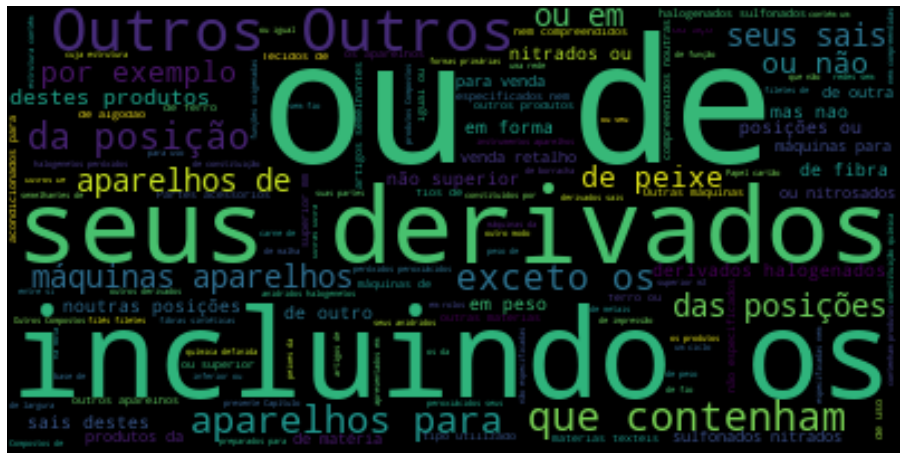

In [76]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(listaTECResumo))

# Display the generated image:
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

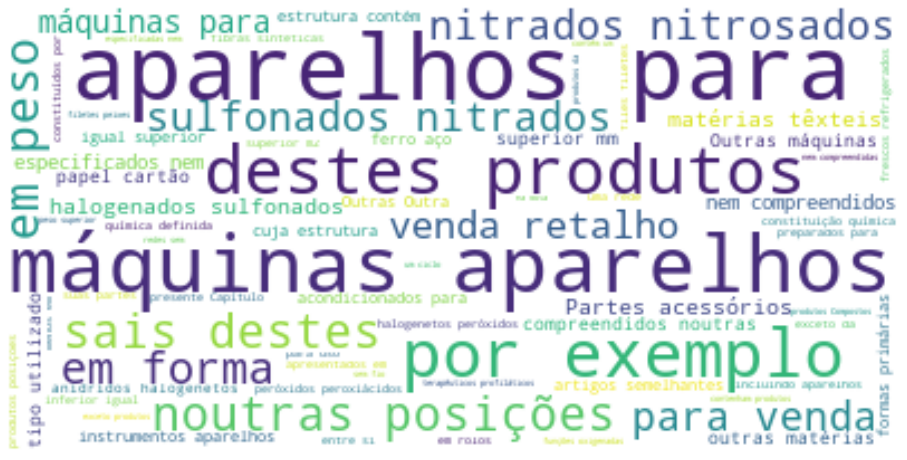

In [77]:
stopwords = set(STOPWORDS)
stopwords.update(['os', 'de', 'seus', 'que', "das", "derivados", 'não', 'posição',
                  'Outros', 'outro', 'Outro', 'ou'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(' '.join(listaTECResumo))
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Com o sklearn, fazer uma "busca" por uma palavra e confirmar sua pontuação em X e em Xtfidf

In [18]:
def get_index_documentos_palavra(X, palavra: str):
    indpalavra = vectorizer.vocabulary_[palavra]
    return np.argwhere(X[:, indpalavra].toarray() > 0), indpalavra

def show_dados_palavra(documentos, X, Xtfidf, palavra:str):
    indexes, indpalavra = get_index_documentos_palavra(X, palavra)
    for linha in indexes:
        inddocumento = linha[0]
        print(documentos[inddocumento])
        print(Xtfid[inddocumento, indpalavra])
        print(X[inddocumento, indpalavra])

In [19]:
indexes, indpalavra = get_index_documentos_palavra(X, 'arruelas')
print(indexes, indpalavra)

[[4756    0]
 [4803    0]
 [4804    0]
 [7097    0]
 [7098    0]
 [7099    0]
 [7100    0]
 [7101    0]
 [7102    0]
 [7103    0]
 [7104    0]
 [7105    0]
 [7106    0]
 [7107    0]
 [7108    0]
 [7205    0]
 [7206    0]
 [7207    0]
 [7208    0]
 [7209    0]
 [7293    0]] 936


In [46]:
show_dados_palavra(corpus, X, Xtfid, 'arruelas')

arruelas outras outras obras plastico obras outras materias posicoes 39 01 39 14
0.35209044782641996
1
perfis recauchutagem outras formas por exemplo varetas tubos perfis artigos por exemplo discos arruelas anilhas borracha vulcanizada
0.2874789688267496
1
outros outras formas por exemplo varetas tubos perfis artigos por exemplo discos arruelas anilhas borracha vulcanizada
0.3380702594906789
1
tira fundos artigos roscados parafusos pinos pernos roscados porcas tira fundos ganchos roscados rebites chavetas cavilhas contrapinos trocos arruelas anilhas incluindo pressao artigos semelhantes ferro fundido ferro aco
0.17171849214498303
1
outros parafusos madeira artigos roscados parafusos pinos pernos roscados porcas tira fundos ganchos roscados rebites chavetas cavilhas contrapinos trocos arruelas anilhas incluindo pressao artigos semelhantes ferro fundido ferro aco
0.18128620627348382
1
ganchos armelas pitoes artigos roscados parafusos pinos pernos roscados porcas tira fundos ganchos rosca

In [20]:
show_dados_palavra(listaTECResumo, X, Xtfid, 'arruelas')

3926.90.10 Arruelas -	Outras Outras obras de plástico e obras de outras matérias das posições 39.01 a 39.14.
0.35209044782641996
1
4006.10.00 -	Perfis para recauchutagem Outras formas (por exemplo, varetas, tubos, perfis) e artigos (por exemplo, discos, arruelas (anilhas*)), de borracha não vulcanizada.
0.2874789688267496
1
4006.90.00 -	Outros Outras formas (por exemplo, varetas, tubos, perfis) e artigos (por exemplo, discos, arruelas (anilhas*)), de borracha não vulcanizada.
0.3380702594906789
1
7318.11.00 --	Tira-fundos -	Artigos roscados: Parafusos, pinos ou pernos, roscados, porcas, tira-fundos, ganchos roscados, rebites, chavetas, cavilhas, contrapinos ou troços, arruelas (anilhas*) (incluindo as de pressão) e artigos semelhantes, de ferro fundido, ferro ou aço.
0.17171849214498303
1
7318.12.00 --	Outros parafusos para madeira -	Artigos roscados: Parafusos, pinos ou pernos, roscados, porcas, tira-fundos, ganchos roscados, rebites, chavetas, cavilhas, contrapinos ou troços, arruela

In [21]:
show_dados_palavra(listaTECResumo, X, Xtfid, 'bolsas')

3006.91.10 Bolsas para colostomia, ileostomia e urostomia --	Equipamentos identificáveis para ostomia -	Outros: Preparações e artigos farmacêuticos indicados na Nota 4 deste Capítulo.
0.25011218243894123
1
3923.21.10 De capacidade inferior ou igual a 1.000 cm3 --	De polímeros de etileno -	Sacos de quaisquer dimensões, bolsas e cartuchos: Artigos de transporte ou de embalagem, de plástico; rolhas, tampas, cápsulas e outros dispositivos para fechar recipientes, de plástico.
0.23243558246964305
1
3923.21.90 Outros --	De polímeros de etileno -	Sacos de quaisquer dimensões, bolsas e cartuchos: Artigos de transporte ou de embalagem, de plástico; rolhas, tampas, cápsulas e outros dispositivos para fechar recipientes, de plástico.
0.2530928044598255
1
3923.29.10 De capacidade inferior ou igual a 1.000 cm3 --	De outro plástico -	Sacos de quaisquer dimensões, bolsas e cartuchos: Artigos de transporte ou de embalagem, de plástico; rolhas, tampas, cápsulas e outros dispositivos para fechar recipie

### Conclusão TFIDF básico


Conforme demonstrado acima, é possível usar a matriz TFIDF para fazer "buscas" de classificação fiscal na TEC. Bastaria consultar os valores TFIDF de cada palavra, combinar, e exibir o "documento" (subitem da TEC) na ordem da pontuação obtida.

## Teste classificador (é possível predizer propabilidade de capítulo pela frase??)

In [22]:
y = [int(linha[:2]) for linha in listaTECResumo]
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split



In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.2)
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.8112835673811284

In [90]:
arruela_plastico = vectorizer.transform(['arruelas plastico'])
print(arruela_plastico)

  (0, 936)	1
  (0, 7102)	1


In [91]:
clf.predict(arruela_plastico)

array([39])

In [92]:
bolsas_couro = vectorizer.transform(['bolsas couro'])
clf.predict(bolsas_couro)

array([84])

In [93]:
bolsas_plastico = vectorizer.transform(['bolsas plastico'])
clf.predict(bolsas_plastico)

array([39])

In [94]:
X_train, X_val, y_train, y_val = train_test_split(Xtfid, y, train_size=0.2)
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.5559251047055925

## Melhorias

A grande fragilidade destas possibilidades de busca demonstradas (usar TF-IDF ou treinar classificadores) é que as palavras buscadas **precisam** estar no vocabulário. Para suprir este problema, são possíveis duas abordagens:

 * Usar um dicionário de sinônimos
 * Usar word embeddings e treinar um classificador com as embeddings (há um problema, como a base tem somente pouco mais de 10.000 linhas e este método envolve redes neurais, provavelmente não será possível treinar redes neurais)